# Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial - Inteligencia Artificial para Juegos (Game IA) - Sesión 8 (Tarea)

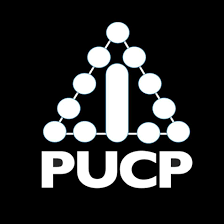
<img src='https://dci.pucp.edu.pe/wp-content/uploads/2014/02/logo-color-pucp1.gif' width=200px>

PhD. Edwin Villanueva, Eng. Daniel Saromo

<font color='orange'>Entorno de `MountainCar-v0` con agente aleatorio y aprendizaje con DDQN. **Ejecutable en Google Colaboratory!**.</font>

## Aprendizaje por refuerzo con Double Deep Q-networks - Entorno `MountainCar-v0`

Esta es una implementacion de un agente Double Deep Q-learning que aprende a mover el carrito para que alcance la bandera amarilla en el entorno `MountainCar-v0` de OpenAI Gym. Adaptado de  https://github.com/keon/deep-q-learning. Se hicieron modificaciones para su ejecución en colab, adaptadas de [aquí](https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t#scrollTo=8-AxnvAVyzQQ).

Es necesario tener instalado: gym, tensorflow y keras. En colab, están preinstalados.

Descripción detallada del entorno: https://github.com/openai/gym/wiki/MountainCar-v0 

Es posible que luego de actualizar pyglet, te pida reiniciar el entorno de ejecución. Es normal eso.

Nota importante: Al ejecutar este notebook, es posible que colab lo cierre repentinamente. Simplemente es cuestión de volver a ejecutarlo de cero.

Completar con su código los campos requeridos y subir su notebook solucionado a la plataforma PAIDEIA. El formato del nombre del notebook es: `Desafio8_APELLIDOPATERNO_NOMBRE.ipynb`.

Es responsabilidad del alumno verificar que el archivo que subió es el correcto. Respetar los lineamientos de la entrega de archivo, ya que influirá en su calificación. La fecha límite de entrega del presente desafío se encuentra en PAIDEIA.

### Clase <b>DDQNAgent</b>

Esta es la clase que implementa el agente Double Deep Q-lerrning. Es una implementacion general, pudiendo ser usado en diferentes entornos de gym u otros. El constructor recibe las dimensiones del estado y la dimesion del vector de acciones posibles 

In [ ]:
!pip install pyglet --upgrade

Requirement already up-to-date: pyglet in /usr/local/lib/python3.6/dist-packages (1.5.14)


In [ ]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

class DDQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size      # tamaño de un estado (numero de atributos que representan un estado)
        self.action_size = action_size    # tamaño del vector de acciones 
        self.memory = deque(maxlen=9000)  # define la memoria del agente (10000 registros como maximo)
        self.gamma = 0.98                 # discount rate 
        self.learning_rate = 0.001        # taza de aprendizaje 
        
        self.epsilon = 1.5               # factor de exploration inicial | 1.0
        self.epsilon_min = 0.02          # factor de exploration minimo | 0.01
        self.epsilon_decay = 0.99       # factor de decaimiento del factor de exploracion | 0.999
        self.model = self._build_model() # construye el modelo neuronal a entrenar 
        
        # construye un 2do modelo neuronal (target_model) para ayudar a estimar el target del 1er modelo (model)   
        self.target_model = self._build_model() 
        self.update_target_model()  # actualiza el target_model copiando los pesos de model
       

    def _build_model(self):
        # Define y compila un modelo de red neuronal de X capas
        
        model = Sequential()   # Informa que las capas que se van agregar son secuenciales
        model.add(Dense(20, input_dim=self.state_size, activation='relu')) # 1ra capa de 20 neuronas, cada neurona recibe state_size entradas (4 para CartPole), activacion relu
        model.add(Dense(20, activation='relu')) # 2da capa de 20 neuronas, funcion de activacion relu
        model.add(Dense(self.action_size, activation='linear')) # 3ra capa (salida) de action_size neuronas (2 para CartPole)
       
        model.compile(loss='mse', optimizer = Adam(lr=self.learning_rate)) # la funcion de perdida es el error cuadratico medio (mse)
  
        return model
    
    # Metodo para copiar los pesos de model a target_model
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # metodo para guardar una transicion del agente (experiencia): (estado, accion, reward resultante, nuevo estado, done)
    # done es un flag que indica que el entorno cayo en un estado terminal
    def remember(self, state, action, reward, next_state, done): 
        self.memory.append((state, action, reward, next_state, done))

    # retorna una accion.  
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:  # retorna una accion aleatoria con probabilidad self.epsilon
            return random.randrange(self.action_size)
        action_values = self.model.predict(state) # obtiene los q valores predichos por el modelo para cada accion
        return np.argmax(action_values[0])  # retorna la accion con el maximo q-valor predicho

    # metodo para actualizar los pesos de model con una muestra (minibatch) de la memoria de experiencias de tamaño batch_size
    def replay(self, batch_size): 
        # obtiene una muestra (minibatch) de la memoria de experiencias
        minibatch = random.sample(self.memory, batch_size) 
        
        # Obtiene arrays de  states, accions, rewards, next_estates  del minibatch
        states = np.array([i[0] for i in minibatch])    
        actions = np.array([i[1] for i in minibatch])   
        rewards = np.array([i[2] for i in minibatch])   
        next_states = np.array([i[3] for i in minibatch]) 
        dones = np.array([i[4] for i in minibatch])       
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)
        
        # Calcula el target Q-value para la accion ejecutada en cada experiencia del batch 
        Qvals_next_states = self.target_model.predict_on_batch(next_states)  # predice Qvals de next_state con el modelo target
        Targets_actions = rewards + self.gamma*(np.amax(Qvals_next_states, axis=1))*(1-dones) # si es terminal -> Target = reward
        
        # Construye el target completo de Q-values para los states de cada experiencia del batch
        Targets = self.model.predict_on_batch(states)  # los target Q-values son los que predice el modelo actual, salvo el correspondiente a la accion tomada
        ind = np.array([i for i in range(batch_size)])
        Targets[[ind], [actions]] = Targets_actions   # actualiza el target Q-value de la accion ejecutada  
        
        # Ajusta el modelo  con pares  [states, Targets] del minibatch
        self.model.fit(states, Targets, epochs=1, verbose=0)
        
        # Si no esta en el minimo factor de exploracion -> hace un decaimiento del factor de exploracion
        if self.epsilon > self.epsilon_min: 
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


### Familiarización con el entorno

[`MountainCar-v0`](https://github.com/openai/gym/wiki/MountainCar-v0)

In [ ]:
env = gym.make('MountainCar-v0')   # carga el modelo MountainCar de gym
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DDQNAgent(state_size, action_size)  # instancia el agente deep q-learning
state_size, action_size

(2, 3)

In [ ]:
state = env.reset()     # resetea el entorno
print("Vanilla State: ", state)
state

Vanilla State:  [-0.42919015  0.        ]


array([-0.42919015,  0.        ])

In [ ]:
score = 0
action = agent.get_action(state)   # obtiene una accion del agente
action

0

In [ ]:
next_state, reward, done, extraInfo = env.step(action)  # ejecuta action en el entorno y obtiene: nuevo estado, reward y flag done (si es estado terminal)
print("Vanilla New State: ", next_state)
next_state, reward, done, extraInfo

Vanilla New State:  [-0.43088878 -0.00169864]


(array([-0.43088878, -0.00169864]), -1.0, False, {})

### Definiendo la función de recompensa

¿Cuál es el dominio de `state[0]`?

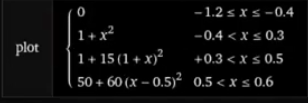

[¿Por qué definimos así la función de reward?](https://www.wolframalpha.com/input/?i=plot+piecewise+%5B%7B+%7B0%2C+-1.2%3C%3Dx%3C%3D-0.4%7D+%2C+%7B1%2Bx%5E2%2C+-0.4%3Cx%3C%3D0.3%7D+%2C+%7B1%2B15*%281%2Bx%29%5E2%2C+%2B0.3%3Cx%3C%3D0.5%7D%2C+%7B50%2B60*%28x-0.5%29%5E2%2C+0.5%3Cx%3C%3D0.6%7D%7D%5D)

In [ ]:
def get_reward(state):
    x=state[0]
    if x >= 0.5:
      print("Car has reached the goal")
      #No está permitido editar las anteriores líneas de código de esta función!
      return 50+60*(-0.5+x)**2
    
    elif 0.3< x <0.5:
      return 1 + 15 * (1+x)**2 
    
    elif -0.4 < x <= 0.3:
      return 1 + x**2
    
    else: 
      return 0

In [ ]:
next_state[0]

-0.43088878227041105

In [ ]:
reward = get_reward(next_state)
reward

0

### Ejecutando el agente en el entorno MountainCar

 

In [ ]:
done = False
batch_size = 128    # tamaño del batch con el que se re-entrena el modelo neuronal
EPISODES = 100      # numero de episodios

env = gym.make('MountainCar-v0')   # carga el modelo MountainCar de gym
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DDQNAgent(state_size, action_size)  # instancia el agente double deep q-learning

score_list = []     # lista para guardar la evolucion del score
epsilon_list = []

for e in range(EPISODES):   # por cada episodio
    state = env.reset()     # resetea el entorno
    state = np.reshape(state, [1, state_size]) # se hace un reshape para que la red neuronal entienda el state
    score = 0
    for step in range(1000):   # prueba el agente hasta 1000!! pasos, sale de este loop cuando se cae en estado terminal (perdida de equilibrio)  
        #env.render()  # renderiza el entorno (por ahora no activarlo, porque de forma nativa, el renderizado no funciona en colab)
        action = agent.get_action(state)   # obtiene una accion del agente
        next_state, reward, done, _ = env.step(action)  # ejecuta action en el entorno y obtiene: nuevo estado, reward y flag done (si es estado terminal)
        reward = get_reward(next_state)
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done) # almacena esta experiencia en la memoria del agente
        state = next_state   # actualiza el estado actual al nuevo estado
        score += reward
        
        if len(agent.memory) > batch_size:  # si hay suficiente experiencias en memoria del agente -> ajusta su modelo neuronal 
            agent.replay(batch_size) 
        
        if done:  # si es estado terminal, imprime resultados del trial. El escore del trial es el numero de pasos que logro ejecutar el agente
            print("episode: {}/{}, score: {}, e: {:.2} | State{}".format(e, EPISODES, score, agent.epsilon, next_state))
            break

    agent.update_target_model()  # actualiza el target_model al final de cada trial
    score_list.append(score)   
    epsilon_list.append(agent.epsilon)
        
env.close()

episode: 0/100, score: 0, e: 0.73 | State[[-0.57336393 -0.00117268]]
episode: 1/100, score: 23.078699966805875, e: 0.097 | State[[-0.70084324 -0.01157693]]
episode: 2/100, score: 0, e: 0.02 | State[[-0.419313    0.01204386]]
episode: 3/100, score: 0, e: 0.02 | State[[-4.73628595e-01 -4.72983207e-04]]
episode: 4/100, score: 0, e: 0.02 | State[[-0.65530328  0.00690106]]
episode: 5/100, score: 0, e: 0.02 | State[[-4.47985556e-01 -2.43206086e-04]]
episode: 6/100, score: 0, e: 0.02 | State[[-0.70985572  0.00301993]]
episode: 7/100, score: 0, e: 0.02 | State[[-0.43657374  0.00073492]]
episode: 8/100, score: 11.547876882968925, e: 0.02 | State[[-4.33768051e-01  1.78421211e-04]]
episode: 9/100, score: 6.943254050888446, e: 0.02 | State[[-0.43256682  0.00065073]]
episode: 10/100, score: 9.2354729468275, e: 0.02 | State[[-0.44075661  0.00199105]]
episode: 11/100, score: 0, e: 0.02 | State[[-4.28218606e-01 -1.84631966e-04]]
episode: 12/100, score: 0, e: 0.02 | State[[-4.24345265e-01  3.35088215e-

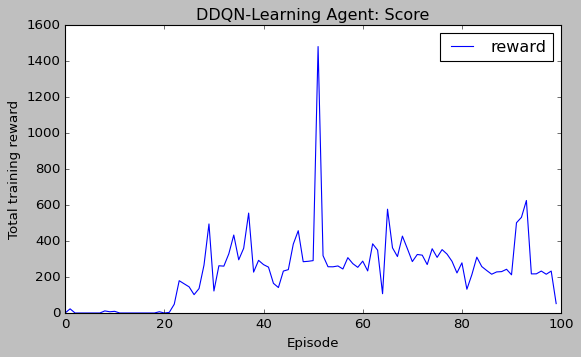

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('classic')

#x = range(train_episodes)

fig, ax = plt.subplots(figsize=(8, 4.5))

ax.set_title('DDQN-Learning Agent: Score')
ax.set_xlabel('Episode')
#ax.set_xlim(-1000,20000)
ax.set_ylabel('Total training reward')
ax.plot(score_list,'-', label='reward')
ax.legend(loc='best')

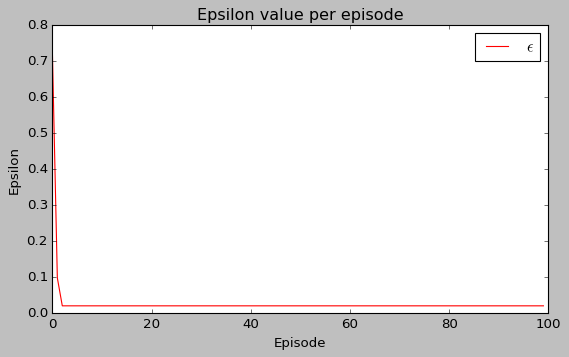

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
#x = range(train_episodes)

fig, ax = plt.subplots(figsize=(8, 4.5))

ax.set_title('Epsilon value per episode')
ax.set_xlabel('Episode')
#ax.set_xlim(-1000,20000)
ax.set_ylabel(r'Epsilon')
ax.plot(epsilon_list,'-', color='r', label=r'$\epsilon$')
ax.legend(loc='best')

¿Por qué la curva no coincide con `1*(0.98)^n`?

### Visualización - install dependancies, takes around 45 seconds

Rendering Dependancies



In [ ]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

Pacman Dependancies

In [ ]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (53.0.0)


### Imports and Helper functions


In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

### Funcion para probar el agente entrenado  en el entorno MountainCar

play_MountainCar()  no realiza entrenamiento, solo actua en el ambiente de acuerdo a su modelo aprendido previamente
 

In [ ]:
def play_MountainCar(agent, trials = 1):
    env = gym.make('MountainCar-v0')
    env = wrap_env(env)
    scores = []
    for trial in range(trials):
        score = 0
        game_memory = []
        state = []
        env.reset()
        for step in range(1000): # en cada trial ejecuta 1000 pasos
            env.render()

            if len(state) == 0:    # si es el primer movimiento  -> escoge una accion aleatoria
                action = random.randrange(0,3)
            else:
                action_values = agent.model.predict(state.reshape(1, 2)) # predice los q valores con la RN del agente
                action = np.argmax(action_values[0])      # retorna la accion con el maximo q-valor predicho

            next_state, reward, done, _  = env.step(action)  # corre el entorno un step ejecutando la accion inferida

            reward = get_reward(next_state)

            score += reward   # acumula el reward (reward=1 en cualquier estado no terminal)
            state = next_state
            game_memory.append([next_state, action])
            if done: 
                print("Play {}/{}, score: {}".format(trial, trials, score))
                break
        scores.append(score)
    env.close()
 
    print("Score medio = {}".format(sum(scores) /float(trials)) )
    
    show_video()

In [ ]:
def play_MountainCar_random(trials = 1):
    env = gym.make('MountainCar-v0')
    env = wrap_env(env)
    scores = []
    for trial in range(trials):
        score = 0
        game_memory = []
        state = []
        env.reset()
        for step in range(1000): # en cada trial ejecuta 1000 pasos
            env.render()

            action = env.action_space.sample()

            next_state, reward, done, _  = env.step(action)  # corre el entorno un step ejecutando la accion inferida

            reward = get_reward(next_state)

            score += reward   # acumula el reward (reward=1 en cualquier estado no terminal)
            state = next_state
            game_memory.append([next_state, action])
            if done: 
                print("Play {}/{}, score: {}".format(trial, trials, score))
                break
        scores.append(score)
    env.close()
 
    print("Score medio = {}".format(sum(scores) /float(trials)) )
    
    show_video()

In [ ]:
#!pip install pyglet --upgrade

In [ ]:
# prueba el agente 5 trials del entorno
play_MountainCar_random(5) #el video solo muestra la ejecución del último trial

Play 0/5, score: 0
Play 1/5, score: 0
Play 2/5, score: 10.385162938569552
Play 3/5, score: 0
Play 4/5, score: 0
Score medio = 2.0770325877139104


### IA en acción!

In [ ]:
# prueba el agente 5 trials del entorno
play_MountainCar(agent,5)  #el video solo muestra la ejecución del último trial

Car has reached the goal
Play 0/5, score: 245.43234513504055
Car has reached the goal
Play 1/5, score: 243.68486599877144
Car has reached the goal
Play 2/5, score: 232.974689537381
Car has reached the goal
Play 3/5, score: 586.9343000694814
Car has reached the goal
Play 4/5, score: 242.4154120191248
Score medio = 310.2883225519598


## Desafío de la semana: Entorno Entorno `MountainCar-v0` (2 puntos en total)

Definir un modelo neuronal en la función `_build_model` y entrenar el agente DDQN. Si deseas, podrías utilizar DQN. Puedes modificar los siguientes hiperparámetros e ir viendo la combinación de valores que te conviene más: `memory`, `gamma`, `epsilon_decay`, `get_reward()` (se deja ya propuesta una función matemática con la que puedes terminar la implementación para calcular el reward), `batch_size` (el valor propuesto es 128), `EPISODES` (el valor propuesto es 100). Recuerda la teoría, por ejemplo, ¿`epsilon_decay` puede ser mayor a 1?


La primera parte del desafío consiste en completar las siguientes funciones de manera que el código compile y se pueda entrenar un agente en el entorno:

- `_build_model`:  0.25 puntos

- `get_reward()`: 0.25 puntos

Es parte del desafío modificar adecuadamente los hiperparámetros del agente, así como las dos funciones previamente mencionadas, para mejorar el desempeño del agente.

El puntaje restante se determina en función a la cantidad de veces en las que el agente logre alcanzar el objetivo en 5 intentos, luego de ejecutar el comando `play_MountainCar(agent,5)`:

- 5 veces: 1.5 puntos
- 4 veces: 1.0 puntos
- 3 veces: 0.5 puntos